Universidad Galileo  
Maestría en Data Science  
Statistical Learning II
Sección U  


   # **Tarea Practica 2: Detección de anomalias y reducción de dimensionalidad**


<p style="text-align: right;">
Henry Giovanni<br/>
Barrientos García<br/>
21001538<br/>
Guatemala, 28 de julio de 2021<br/>
</p>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pandas
%matplotlib inline
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [13]:
dataset = np.loadtxt("estaturas.xlsx - normales.csv", delimiter=',', skiprows=1)
dataset_cv = np.loadtxt("estaturas.xlsx - valtest(normales).csv", delimiter=',', skiprows=1)
dataset_cv = np.array_split(dataset_cv, 2)[0]
dataset_tg = np.loadtxt("estaturas.xlsx - valtest(anomalias).csv", delimiter=',', skiprows=1)
dataset_tg = np.array_split(dataset_tg, 2)[0]
ds_rows = np.shape(dataset)[0]
ds_cols = np.shape(dataset)[1]

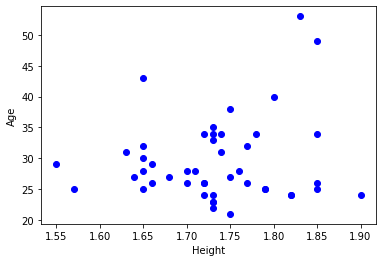

In [8]:
plt.xlabel('Height')
plt.ylabel('Age')
plt.plot(dataset[:,0], dataset[:,1], 'bo')
plt.show()

In [9]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs, gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) 
        #print(predictions)
        f = f1_score(gt, predictions, average='binary')
        #print(f)
        #print('------')
        if f > best_f1:
            #print('----')
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

In [11]:
mu, sigma = estimateGaussian(dataset)
p = multivariateGaussian(dataset, mu, sigma)

In [14]:
#selecting optimal value of epsilon using cross validation
p_cv = multivariateGaussian(dataset_cv, mu, sigma)
fscore, ep = selectThresholdByCV(p_cv, dataset_tg)
print(ep)

ValueError: Found input variables with inconsistent numbers of samples: [2, 4]

In [11]:
# mu = np.mean(dataset, axis=0)
# sigma = np.std(dataset, axis=0)
# lower_limit = mu - 2*sigma
# upper_limit = mu + 2*sigma
# print(mu)
# print(sigma)
# print(lower_limit)
# print(upper_limit)

[ 1.7326087  29.52173913] [0.07452559 6.63567149]
[ 1.58355751 16.25039615]
[ 1.88165989 42.79308211]


array([0.07452559, 6.63567149])

In [18]:
observed_by_cluster = []
checkpoint_at = 30

def get_points_clusters(k, num_test):
    cluster_points = np.empty((0, 2))
    if (num_test >= 2):
        #Determinar los nuevos puntos de clusters basado en la media de los puntos obtenidos en la ultima iteracion.
        for i in range(k):
            mean_h = np.mean(observed_by_cluster[i][:, 0])
            mean_a = np.mean(observed_by_cluster[i][:, 1])
            cluster_points = np.append(cluster_points, [[mean_h, mean_a]], axis=0)
    else:
        # en la primera iteracion, determinar los puntos de los clusters mediante un random
        min_h = np.min(dataset[:,0])
        max_h = np.max(dataset[:,0])
        min_a = np.min(dataset[:,1])
        max_a = np.max(dataset[:,1])
        for i in range(k):
            random_h = random.uniform(min_h, max_h)
            random_a = random.randint(min_a, max_a)
            cluster_points = np.append(cluster_points, [[random_h, random_a]], axis=0)
    if ((num_test%checkpoint_at) == 0):
        print("kmeans CENTROIDS\n", cluster_points)
    return cluster_points

In [28]:
pruebas = 5
max_iterations = 80
sse_ncluster = np.empty((0, 2))
for test in range(pruebas):
    print("\n\nkmeans *** PRUEBA: {} ***".format(test))
    k = test + 1
    iteration = 1
    do_execute = True
    points_clusters = get_points_clusters(k, iteration)   # (re)define los centros de cada cluster
    dist_by_cluster = None
    while (do_execute):
        if ((iteration%checkpoint_at) == 0):
            print("kmeans iteration", iteration)
        # se inicializan las variables que almacenan datos importantes.
        dist_by_cluster = np.empty((0, k))   # para la distancia entre cada punto y cada cluster
        d_each_cluster = []
        for i in range(k):
            d_each_cluster.append(np.empty((0)))   #to save set of distance from observed to cluster
            observed_by_cluster.append(np.empty((0, 2)))   #2 in this case is for height and age

        # para cada cluster k, determinar la distancia con cada punto observado
        for nk in range(k):
            # square root of distances between observed height and current cluster random height
            sqr_distances_h = np.power( np.subtract(dataset[:,0], points_clusters[nk, 0]), 2)
            # square root of distances between observed age and current cluster random age
            sqr_distances_a = np.power( np.subtract(dataset[:,1], points_clusters[nk, 1]), 2)

            sqr_distances_ha = sqr_distances_h.reshape(ds_rows, 1)
            sqr_distances_ha = np.hstack( (sqr_distances_ha, np.atleast_2d(sqr_distances_a).T) )
            dist = np.sum(sqr_distances_ha, axis=1)        
            if (np.shape(dist_by_cluster)[0] == 0):
                dist_by_cluster = dist.reshape(ds_rows, 1)
            else:
                dist_by_cluster = np.hstack( (dist_by_cluster, np.atleast_2d(dist).T))

        # determinar la distancia menor entre cada punto y cada cluster.
        for d_index, dist in enumerate(dist_by_cluster):
            n_cluster = np.argmin(dist)
            curr_cluster = d_each_cluster[n_cluster]
            curr_cluster = np.append(curr_cluster, dist[n_cluster])
            d_each_cluster[n_cluster] = curr_cluster
            curr_cluster = observed_by_cluster[n_cluster]
            curr_cluster = np.vstack((curr_cluster, dataset[d_index]))
            observed_by_cluster[n_cluster] = curr_cluster

        iteration = iteration + 1
        centroids = get_points_clusters(k, iteration)
        # condiciones de salida
        if (iteration == max_iterations
           or (centroids == points_clusters).all()):
            do_execute = False
            print("kmeans centroids:", centroids)
            print("kmeans points_clusters:", points_clusters)
            print("kmeans ***********punto de salida @ {}\n\n".format(iteration))
        points_clusters = centroids
    
    current_sse = np.sum(np.sum(dist_by_cluster, axis=0))
    sse_ncluster = np.append(sse_ncluster, [[k, current_sse]], axis=0)




kmeans *** PRUEBA: 0 ***
kmeans CENTROIDS
 [[ 1.74281913 33.28168116]]
kmeans iteration 20
kmeans CENTROIDS
 [[ 1.74230215 33.09130435]]
kmeans iteration 40
kmeans CENTROIDS
 [[ 1.74183499 32.91927711]]
kmeans iteration 60
kmeans CENTROIDS
 [[ 1.74141079 32.76306847]]
kmeans centroids: [[ 1.74141079 32.76306847]]
kmeans points_clusters: [[ 1.74143108 32.77053697]]
kmeans ***********punto de salida @ 80




kmeans *** PRUEBA: 1 ***
kmeans CENTROIDS
 [[ 1.74138219 32.80652291]
 [ 1.73020082 25.5123131 ]]
kmeans iteration 20
kmeans CENTROIDS
 [[ 1.74137881 32.86380985]
 [ 1.7301464  25.51313334]]
kmeans iteration 40
kmeans CENTROIDS
 [[ 1.74137554 32.91924521]
 [ 1.73009421 25.51392013]]
kmeans iteration 60
kmeans CENTROIDS
 [[ 1.74137237 32.97291735]
 [ 1.7300441  25.51467549]]
kmeans centroids: [[ 1.74137237 32.97291735]
 [ 1.7300441  25.51467549]]
kmeans points_clusters: [[ 1.74137253 32.97027432]
 [ 1.73004655 25.51463844]]
kmeans ***********punto de salida @ 80




kmeans *** PRUEB

array([[1.00000000e+00, 2.51125295e+03],
       [2.00000000e+00, 5.33713687e+03],
       [3.00000000e+00, 7.65105443e+03],
       [4.00000000e+00, 2.65636772e+04],
       [5.00000000e+00, 3.39085072e+04]])

## Análisis de gráfica de codo

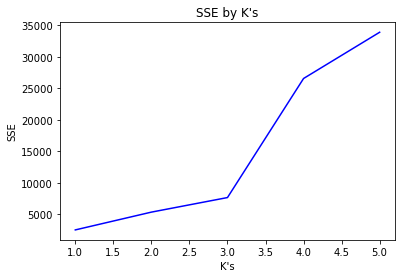

In [29]:
plt.plot(sse_ncluster[:,0], sse_ncluster[:,1], c="blue")
plt.title("Elbow curve")
plt.xlabel("K's")
plt.ylabel("SSE")
plt.show()

## Selección del valor de K
Luego de varias iteraciones y pruebas de ejecución, siempre se ha llegado a la misma conclusión acerca de que el valor óptimo para tomar como número de clústers es el **3**. Esto se puede aseverar al realizar un análisis de la gráfica de codo (*Elbow curve*). Pues aunque para nuestro caso particular el error va aumentando, hay un punto (cluster = 3), donde empieza a hacerlo mas abruptamente.  

## Análisis y conclusión
Dadas las ejecuciones que realizamos para nuestro laboratorio y el análisis que se obtuvo de los distintos centroides obtenidos en las iteraciones junto con la gráfica de codo, podemos concluir que sí es válido utilizar el 'método del codo' para este problema.  

# ESTIMACIONES/PREDICCIONES
A continuación se realizarán algunas estimaciones a partir de datos de prueba.  

In [30]:
valtest = np.loadtxt("estaturas.xlsx - valtest(normales).csv", delimiter=',', skiprows=1)
valtest

array([[ 1.82, 25.  ],
       [ 1.8 , 27.  ],
       [ 1.6 , 31.  ],
       [ 1.6 , 35.  ],
       [ 1.82, 30.  ],
       [ 1.76, 32.  ],
       [ 1.79, 31.  ],
       [ 1.61, 31.  ]])